In [141]:
import datefinder
import pandas as pd
from bs4 import BeautifulSoup
import os
import glob
import unidecode
from collections import defaultdict
import codecs
from tqdm import tqdm_notebook as tqdm
import datetime

In [149]:
council_meetings = glob.glob('../council_meetings/*/*')

In [150]:
meeting_dfs = []

In [276]:
for meeting_file_path in tqdm(council_meetings):
    html = codecs.open(meeting_file_path, encoding='utf-8').read()
    soup = BeautifulSoup(html, 'lxml')

    ## get date
    meeting_file = os.path.basename(meeting_file_path)
    fp_datepart = meeting_file.split('_')[1].replace('.htm', '')
    minutes_date = datetime.datetime.strptime(fp_datepart, '%m%d%Y')
    
    ## get all links
    minute_links = pd.Series(soup.find_all('a', href=lambda href: href and "cityclerk.lacity.org" in href))

    ## if links exist, parse...
    if len(minute_links)> 0:
        try:
            metadata_df = pd.concat([
                minute_links.apply(lambda x: x['href']).to_frame('link'),
                minute_links.apply(lambda x: x.get_text()).apply(unidecode.unidecode).to_frame('bill_number'),
            ], axis=1).set_index('bill_number')

            ## get text
            htmnl_text = unidecode.unidecode(soup.get_text())
            html_lines = list(map(lambda x: x.strip(), htmnl_text.split('\n')))

            ## parse text
            minutes_metadata = defaultdict(list)
            in_bill = False
            for line in html_lines:
                if line in metadata_df.index:
                    in_bill = line

                if in_bill:
                    minutes_metadata[in_bill].append(line)

            ## put it together
            metadata_df = metadata_df.merge(pd.Series(minutes_metadata).to_frame('text'), left_index=True, right_index=True)
            metadata_df['text'] = (
                metadata_df
                 .apply(lambda x: list(filter(lambda y: (y != '') and (y != x.name), x['text'])), axis=1)
                 .str.join(' ')
            )
            metadata_df['date'] = minutes_date

            meeting_dfs.append(metadata_df)
        except:
            print('failed on %s...' % meeting_file)

failed on clkreferralmemo992789_01122015.htm...
failed on clkreferralmemo9103082_04252016.htm...


In [277]:
all_meetings_dfs = pd.concat(meeting_dfs)

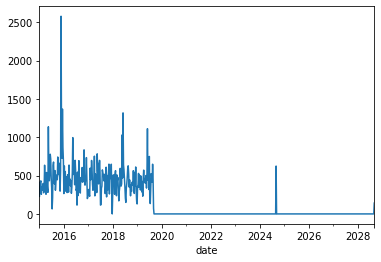

In [278]:
%matplotlib inline
all_meetings_dfs.assign(c=1).groupby(pd.Grouper(key='date', freq='7D'))['c'].sum().plot()

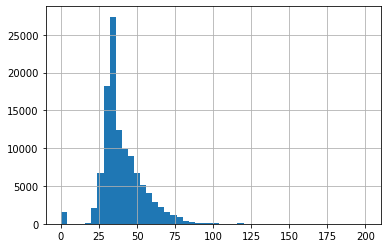

In [279]:
all_meetings_dfs['text'].str.split().str.len().hist(bins=50, range=(0, 200))

In [293]:
import util
from importlib import reload
import swifter

In [295]:
reload(util)

<module 'util' from 'C:\\Users\\alexa\\Projects\\usc-research\\newspaper-pages\\notebooks\\util.py'>

In [ ]:
all_meetings_dfs['processed_text'] = all_meetings_dfs['text'].swifter.apply(util.preprocess)

In [303]:
all_meetings_dfs.to_csv("../council_meetings/processed_council_meetings.csv")